## daart training example
This notebook demonstrates how to create a daart model (as well as the data generator), train the model, then assess its performance.

The python script located at `daart/examples/fit_models.py` generalizes these steps and allows users to fit multiple models from the command line more easily. The script utilizes yaml configuration files to set hyperparameters; examples can be found in the directory `daart/configs`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from daart.data import DataGenerator
from daart.eval import get_precision_recall, plot_training_curves
from daart.models import Segmenter
from daart.transforms import ZScore

### define data paths

In [2]:
# choose one experiment for training
expt_id = '201016_G23xU1_Fly1_020_coronal'

# where data is stored
base_dir = os.path.join(os.path.dirname(os.getcwd()), 'my_data')

# where model results will be saved
model_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results')

# DLC markers
markers_file = os.path.join(base_dir, 'markers', expt_id + '_labeled.npy')
# heuristic labels
labels_file = os.path.join(base_dir, 'labels-heuristic', expt_id + '_labels.pkl')
# hand labels
hand_labels_file = os.path.join(base_dir, 'labels-hand', expt_id + '_labels.csv')

### build data generator

In [3]:
# define data generator signals
signals = ['markers', 'labels_weak', 'labels_strong']
transforms = [ZScore(), None, None]
paths = [markers_file, labels_file, hand_labels_file]
device = 'cpu'  # 'cpu' | 'cuda'

trial_splits = {
    'train_tr': 9,
    'val_tr': 1,
    'test_tr': 0,
    'gap_tr': 0
}

# build data generator
data_gen = DataGenerator(
    [expt_id], [signals], [transforms], [paths], device=device, batch_size=500, 
    trial_splits=trial_splits)
print(data_gen)

Generator contains 1 SingleDataset objects:
201016_G23xU1_Fly1_020_coronal
    signals: ['markers', 'labels_weak', 'labels_strong']
    transforms: OrderedDict([('markers', ZScore()), ('labels_weak', None), ('labels_strong', None)])
    paths: OrderedDict([('markers', '/home/aymanns/daart/my_data/markers/201016_G23xU1_Fly1_020_coronal_labeled.npy'), ('labels_weak', '/home/aymanns/daart/my_data/labels-heuristic/201016_G23xU1_Fly1_020_coronal_labels.pkl'), ('labels_strong', '/home/aymanns/daart/my_data/labels-hand/201016_G23xU1_Fly1_020_coronal_labels.csv')])



In [4]:
# see what data generator returns
data, dataset = data_gen.next_batch('train')
print(data.keys())
print()
print(data['batch_idx'])
print(data['markers'].shape)
print(data['labels_weak'].shape)
print(data['labels_strong'].shape)

dict_keys(['markers', 'labels_weak', 'labels_strong', 'batch_idx'])

tensor([2])
torch.Size([1, 500, 72])
torch.Size([1, 500])
torch.Size([1, 500])


### build model

In [5]:
# define model params
hparams = {
    'model_type': 'dtcn',
    'input_size': 72,       # dimensionality of markers
    'output_size': 5,       # number of classes
    'n_hid_layers': 2,      # hidden layers in network
    'n_hid_units': 32,      # hidden units per hidden layer
    'n_lags': 4,            # half-width of temporal convolution window
    'activation': 'lrelu',  # layer nonlinearity
    'lambda_weak': 1,       # hyperparam on classifying weak (heuristic) labels
    'lambda_strong': 0.5,   # hyperparam on classifying strong (hand) labels
    'lambda_pred': 0.5      # hyperparam on one-step-ahead prediction
}

# build model
model = Segmenter(hparams)
model.to(device)
print(model)


TCN architecture
------------------------
Encoder:
    0: DilationBlock
        0: Conv1d(72, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        1: LeakyReLU(negative_slope=0.05)
        2: Dropout2d(p=0.2, inplace=False)
        3: Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        4: LeakyReLU(negative_slope=0.05)
        5: Dropout2d(p=0.2, inplace=False)
        6: residual connection
        7: LeakyReLU(negative_slope=0.05)

    1: DilationBlock
        0: Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(8,), dilation=(2,))
        1: LeakyReLU(negative_slope=0.05)
        2: Dropout2d(p=0.2, inplace=False)
        3: Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(8,), dilation=(2,))
        4: LeakyReLU(negative_slope=0.05)
        5: Dropout2d(p=0.2, inplace=False)
        6: residual connection
        7: LeakyReLU(negative_slope=0.05)

Classifier:
    0: Linear(in_features=32, out_features=5, bias=True)

Predictor:
    0: DilationBlock
  

### train model

In [6]:
# define training params
train_kwargs = {
    'learning_rate': 1e-4,       # adam learning rate
    'l2_reg': 0,                 # general l2 reg on parameters
    'min_epochs': 10,            # minimum number of training epochs
    'max_epochs': 1000,          # maximum number of training epochs
    'val_check_interval': 1,     # requency with which to log performance on val data
    'rng_seed_train': 0,         # control order in which data are served to model
    'enable_early_stop': False,  # True to use early stopping; False will use max_epochs
    'early_stop_history': 10,    # epochs over which to average early stopping metric
    'save_last_model': False,    # true to save out last (as well as best) model
}

# fit model!
model.fit(data_gen, save_path=model_save_path, **train_kwargs)

# save training curves
plot_training_curves(
    os.path.join(model_save_path, 'metrics.csv'), dtype='train', 
    save_file=os.path.join(model_save_path, 'train_curves'), format='png')
plot_training_curves(
    os.path.join(model_save_path, 'metrics.csv'), dtype='val', 
    save_file=os.path.join(model_save_path, 'val_curves'), format='png')

  0%|          | 0/1001 [00:00<?, ?it/s]/home/aymanns/.conda/envs/daart/lib/python3.6/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
100%|██████████| 1001/1001 [08:41<00:00,  1.92it/s]


### evaluate model

In [7]:
# load hand labels
from numpy import genfromtxt
labels = genfromtxt(hand_labels_file, delimiter=',', dtype=np.int, encoding=None)
labels = labels[1:, 1:]  # get rid of headers, etc.
states = np.argmax(labels, axis=1)

# get model predictions for each time point
predictions = model.predict_labels(data_gen)['labels']

# compute precision and recall for each behavior type
scores = get_precision_recall(
    states, np.argmax(np.vstack(predictions[0]), axis=1), background=0)

### plot results

resting 1.0 1.0
walking 1.0 1.0
grooming 1.0 1.0
hindgrooming 1.0 1.0


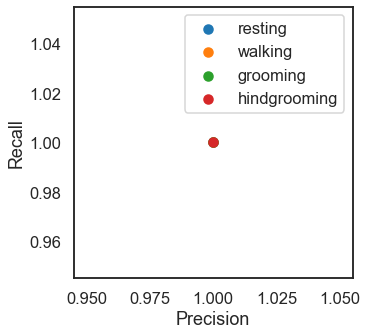

In [8]:
class_names = ['resting', 'walking', 'grooming', 'hindgrooming']
n_classes = len(class_names)

# get rid of background class
if len(scores['precision']) != len(class_names):
    precision = scores['precision'][1:]
    recall = scores['recall'][1:]
else:
    precision = scores['precision']
    recall = scores['recall']
    
# plot precision and recall for each class
plt.figure(figsize=(5, 5))
for n, name in enumerate(class_names):
    print(name, precision[n], recall[n])
    plt.scatter(precision[n], recall[n], label=name)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()

plt.show()